# Chapter 7: Data-Driven Dynamical Systems

Course title:

**MECH 575T: Data-driven modeling and control (Self-directed)**

Reference text:

**Data-Driven Science and Engineering, by Steve Brunton**

## Contents

1. Computing the Dynamic Matrix Decomposition (DMD)

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from platform import python_version
python_version()

'3.6.7'

In [3]:
plot_dir = 'plots'
if not os.path.exists(plot_dir):
    os.mkdir(plot_dir)

## Computing the DMD

In [4]:
# Code from Steve Brunton's book

def dmd_SB(X, Xprime, r):
    
    # Step 1
    U, Sigma, VT = np.linalg.svd(X, full_matrices=0)
    Ur = U[:, :r]
    Sigmar = np.diag(Sigma[:r])
    VTr = VT[:r, :]
    
    # Step 2
    Atilde = np.linalg.solve(Sigmar.T, (Ur.T @ Xprime @ VTr.T).T).T
    
    # Step 3
    Lambda, W = np.linalg.eig(Atilde)
    Lambda = np.diag(Lambda)
    
    # Step 4
    Phi = Xprime @ np.linalg.solve(Sigmar.T, VTr).T @ W
    alpha1 = Sigmar @ VTr[:, 0]
    b = np.linalg.solve(W @ Lambda, alpha1)
    
    return Phi, Lambda, b


In [5]:
np.random.seed(1)

def add_noise(x, sigma):
    """Adds Gaussian noise to array x.
    """
    return x + sigma * np.random.randn(*x.shape)


def system(t, noise=False, sigma=0.01):
    """Simulates a dynamic system involving sin waves.
    """
    x = np.stack([
        np.sin(t), 
        np.sin(t - 1), 
        np.sin(t - 2)
    ])
    if noise:
        return add_noise(x, sigma)
    else:
        return x

system(0)

array([ 0.        , -0.84147098, -0.90929743])

In [6]:
# Prepare data sets
t = np.linspace(0, 2*np.pi, 200)

# With noise
df = pd.DataFrame(
    data=system(t).T, 
    index=pd.Index(t, name='t'),
    columns=['$x_1$', '$x_2$', '$x_3$']
)

# Without noise
df_noisy = pd.DataFrame(
    data=system(t, noise=True).T, 
    index=pd.Index(t, name='t'),
    columns=['$x_1$', '$x_2$', '$x_3$']
)

assert df.shape == (200, 3)
assert df_noisy.shape == (200, 3)
df.head()

,$x_1$,$x_2$,$x_3$
t,,,
0.000000,0.000000,-0.841471,-0.909297
0.031574,0.031569,-0.823995,-0.921981
0.063148,0.063106,-0.805698,-0.933746
0.094721,0.094580,-0.786597,-0.944580
0.126295,0.125960,-0.766713,-0.954473


In [7]:
# Prepare samples of data for DMD

# Only use portion of data
nd = 25
x = df.iloc[:nd].values.T
x_prime = df.iloc[1:nd+1].values.T

assert x.shape == x_prime.shape
x.shape, x_prime.shape

((3, 25), (3, 25))

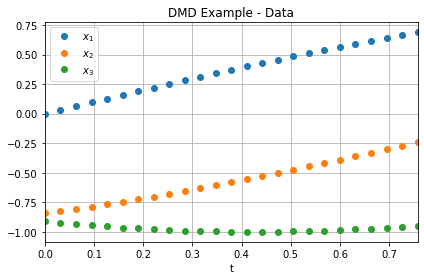

In [8]:
index = pd.Index(t[:nd], name='t')
pd.DataFrame(x.T, index=index,
             columns=df.columns).plot(style='o')
plt.title('DMD Example - Data')
plt.grid()
plt.tight_layout()
plt.savefig('plots/dmd_example_data.pdf')
plt.show()

In [9]:
print(f"x\n{x[:, :5].round(3)}")
print(f"\nx_prime\n{x_prime[:, :5].round(3)}")

x
[[ 0.     0.032  0.063  0.095  0.126]
 [-0.841 -0.824 -0.806 -0.787 -0.767]
 [-0.909 -0.922 -0.934 -0.945 -0.954]]

x_prime
[[ 0.032  0.063  0.095  0.126  0.157]
 [-0.824 -0.806 -0.787 -0.767 -0.746]
 [-0.922 -0.934 -0.945 -0.954 -0.963]]


### Step 1 - Compute the SVD of $\mathbf{X}$

In [10]:
U, Sigma, VT = np.linalg.svd(x,full_matrices=0)
U.shape, np.diag(Sigma).shape, VT.conj().T.shape

((3, 3), (3, 3), (25, 3))

In [11]:
Sigma.round(4)

array([5.9143, 1.383 , 0.    ])

In [12]:
# Truncate
r = 2

Ur = U[:,:r]
Sigmar = np.diag(Sigma[:r])
VTr = VT[:r,:]

Ur.shape, Sigmar.shape, VTr.conj().T.shape

((3, 2), (2, 2), (25, 2))

In [13]:
Ur.round(4)

array([[-0.3024, -0.77  ],
       [ 0.4814, -0.6321],
       [ 0.8227,  0.0869]])

### Step 2 - Compute $\tilde{\mathbf{A}}$

In [14]:
Atilde = np.linalg.solve(Sigmar.T, (Ur.T @ x_prime @ VTr.T).T).T
Atilde.round(4)

array([[ 0.9978, -0.0311],
       [ 0.0321,  1.0012]])

In [15]:
# Choose a snapshot
i = 0
x[:, i].reshape(-1,1)

array([[ 0.        ],
       [-0.84147098],
       [-0.90929743]])

In [16]:
# Reduced state estimate
x_tilde = Ur.conj().T.dot(x[:, i].reshape(-1,1))
x_tilde

array([[-1.1531561 ],
       [ 0.45290864]])

In [17]:
x_tilde_prime = Atilde.dot(x_tilde)
x_tilde_prime

array([[-1.16472374],
       [ 0.41645244]])

In [18]:
# Next snapshot prediction
Ur.dot(x_tilde_prime)

array([[ 0.03156855],
       [-0.82399503],
       [-0.92198138]])

In [19]:
# Next snapshot actual data
x_prime[:, i].reshape(-1,1)

array([[ 0.03156855],
       [-0.82399503],
       [-0.92198138]])

### Step 3 - Spectral decomposition of $\tilde{\mathbf{A}}$

In [20]:
Lambda, W = np.linalg.eig(Atilde)
Lambda = np.diag(Lambda)
Lambda.round(4)

array([[0.9995+0.0316j, 0.    +0.j    ],
       [0.    +0.j    , 0.9995-0.0316j]])

### Step 4 - Reconstruct DMD modes

In [21]:
Phi = x_prime @ np.linalg.solve(Sigmar.T, VTr).T @ W
alpha1 = Sigmar @ VTr[:, 0]
b = np.linalg.solve(W @ Lambda, alpha1)

In [22]:
Phi.round(4)

array([[-0.5301-0.2288j, -0.5301+0.2288j],
       [-0.4789+0.3224j, -0.4789-0.3224j],
       [ 0.0126+0.5772j,  0.0126-0.5772j]])

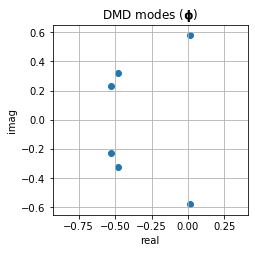

In [23]:
plt.figure(figsize=(3.5, 3.5))
plt.scatter(Phi.real, Phi.imag)
plt.title(r'DMD modes ($\mathbf{\phi}$)')
plt.xlabel('real')
plt.ylabel('imag')
plt.grid()
plt.axis('equal')
plt.savefig('plots/dmd-modes.pdf')
plt.show()

In [24]:
alpha1.round(4)

array([-1.1532,  0.4529])

In [25]:
b.round(4)

array([0.3432+0.7951j, 0.3432-0.7951j])

In [26]:
# Check results with Steve Brunton's code for DMD
# dmd_SB returns Phi, Lambda, b
result_check = dmd_SB(x, x_prime, r)
assert np.array_equal(Phi, result_check[0])
assert np.array_equal(Lambda, result_check[1])
assert np.array_equal(b, result_check[2])

## DMD Expansion

In [27]:
# Predict future snapshots (beyond data)

def predict(m, Phi, Lambda, b):
    temp = Phi.copy()
    n = Phi.shape[0]
    x = np.zeros((n, m))
    for k in range(m):
        x[:, k] = temp.dot(b).real
        temp = temp.dot(Lambda)
    return x

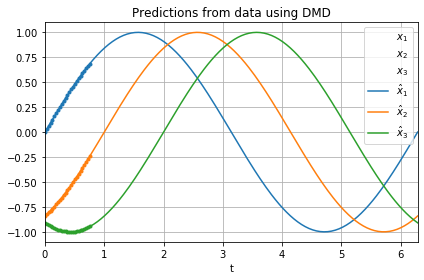

In [28]:
# DMD predictions without noise

nd = 25
x = df.iloc[:nd].values.T
x_prime = df.iloc[1:nd+1].values.T
assert x.shape == x_prime.shape

# Compute DMD
Phi, Lambda, b = dmd_SB(x, x_prime, r)
x_pred = predict(200, Phi, Lambda, b)

data_df = pd.DataFrame(x.T, index=df.index[:nd],
                       columns=df.columns)
pred_df = pd.DataFrame(x_pred.T, index=df.index,
                       columns=[r'$\hat{x}_%d$' % (i+1) for i in range(3)])

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
ax = data_df.plot(label='model', style='.', color=colors)
pred_df.plot(ax=ax, label='model', style='-')
plt.title('Predictions from data using DMD')
plt.grid()
plt.tight_layout()
plt.savefig('plots/dmd_example.pdf')
plt.show()

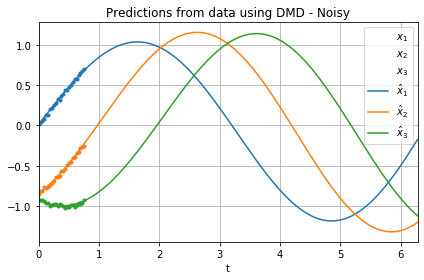

In [29]:
# DMD predictions with noise

nd = 25
x = df_noisy.iloc[:nd].values.T
x_prime = df_noisy.iloc[1:nd+1].values.T
assert x.shape == x_prime.shape

# Compute DMD
Phi, Lambda, b = dmd_SB(x, x_prime, r)
x_pred = predict(200, Phi, Lambda, b)

data_df = pd.DataFrame(x.T, index=df.index[:nd],
                       columns=df.columns)
pred_df = pd.DataFrame(x_pred.T, index=df.index,
                       columns=[r'$\hat{x}_%d$' % (i+1) for i in range(3)])

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
ax = data_df.plot(label='model', style='.', color=colors)
pred_df.plot(ax=ax, label='model', style='-')
plt.title('Predictions from data using DMD - Noisy')
plt.grid()
plt.tight_layout()
plt.savefig('plots/dmd_example_noisy.pdf')
plt.show()

## My code for DMD (Not working)

In [30]:
def dmd_BT(x, x_prime, r):
    """Compute dynamic matrix decomposition.
    """

    # Step 1
    u, sigma, vh = np.linalg.svd(x, full_matrices=False)
    
    u_r = u[:, :r]
    sigma_r = np.diag(sigma[:r])
    v_r = vh[:r, :]

    # Step 2
    a_tilde = np.linalg.solve(sigma_r.T, (u_r.conj().T.dot(x_prime).dot(v_r.conj().T).T).T)
    # a_tilde2 = u_r.conj().T.dot(x_prime).dot(v_r).dot(np.linalg.inv(sigma_r))
    # assert np.array_equal(a_tilde, a_tilde2)
    
    # Step 3
    lam, w = np.linalg.eig(a_tilde) 

    # Step 4
    phi = x_prime.dot(np.linalg.solve(sigma_r.T, v_r).T).dot(w)
    alpha1 = sigma_r.dot(v_r[:, 0])    
    b = np.linalg.solve(w.dot(np.diag(lam)), alpha1)
    
    return phi, lam, b

In [31]:
phi, lam, b = dmd_BT(x, x_prime, r=2)

In [32]:
phi

array([[-0.7331808 -0.0721805j , -0.7331808 +0.0721805j ],
       [-0.64962851+0.10199388j, -0.64962851-0.10199388j],
       [ 0.03863092+0.18280444j,  0.03863092-0.18280444j]])

In [33]:
lam

array([1.00083586+0.03083879j, 1.00083586-0.03083879j])

In [34]:
b

array([0.30609755+2.594028j, 0.30609755-2.594028j])

In [35]:
phi, lam, b = dmd_SB(x, x_prime, r=2)

In [36]:
phi

array([[-0.5157523 -0.22459j   , -0.5157523 +0.22459j   ],
       [-0.51086697+0.3173545j , -0.51086697-0.3173545j ],
       [-0.03095296+0.56879698j, -0.03095296-0.56879698j]])

In [37]:
lam

array([[1.00083586+0.03083879j, 0.        +0.j        ],
       [0.        +0.j        , 1.00083586-0.03083879j]])

In [38]:
b

array([0.33201542+0.79439366j, 0.33201542-0.79439366j])